# Sentiment Analysis of IMDB Movie Reviews

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

Side note for profs: I have done NLP analysis before,so this work is using as a x template as a baseline. 

## Data Processing 
**Import necessary libraries**

In [5]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

**Import the training dataset**

In [6]:
#importing the training data
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


**Exploratery data analysis**

In [7]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

In [8]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

## Exploratory Data Analysis

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_18682/539831338.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_zeros,ax=ax1,color='Blue')
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_18682/539831338.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_on

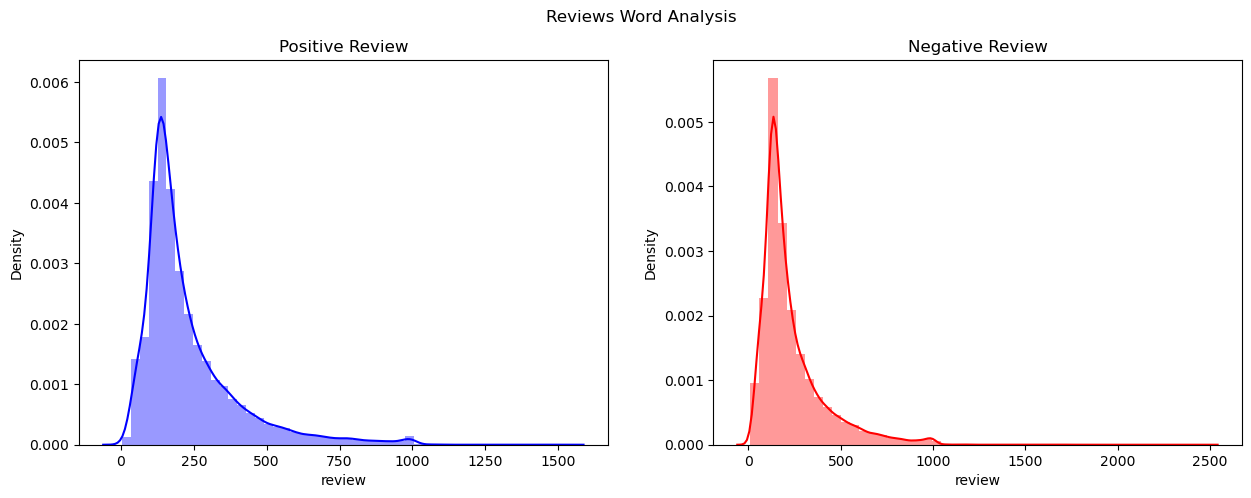

In [9]:
#Analyse the count of words in each segment- both positive and negative reviews
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


    
count_good=imdb_data[imdb_data['sentiment']=='positive']
count_bad=imdb_data[imdb_data['sentiment']=='negative']
count_good_words=count_good['review'].str.split().apply(lambda z:cal_len(z))
count_bad_words=count_bad['review'].str.split().apply(lambda z:cal_len(z))
# print("Positive Review Words:" + str(count_good_words))
# print("Negative Review Words:" + str(count_bad_words))
plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")

Analyzing word count for positive and negative reviews, it seens that negative reviews have a much longer tails, which might result from angry viewers write long critics for bad movies. It shows us a potential of using word count to classify positive or negative sentiments. 

**Spliting the training dataset**

In [10]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Removing html strips and noise text**

In [91]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Removing special characters**

In [90]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming**

In [92]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Removing stopwords**

In [93]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [94]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'between', 'me', 'by', 'yourself', 'for', 'further', 'once', "it's", 'where', 'mightn', 'you', 'wouldn', "you're", 'didn', 'i', 're', "didn't", 'your', 'd', 'some', 'ain', 'his', "doesn't", 'she', 'if', 'with', 'after', 'y', 'we', 'have', "you'd", 'what', 'then', 'do', 'shan', 'himself', 'a', 'theirs', "wouldn't", 'him', 'how', 'does', 'over', 've', 'too', 'against', 'when', 'in', 'from', 'it', 'again', 'couldn', 'until', "weren't", 'our', 'won', 'off', 'such', "wasn't", 'they', 'an', 'o', 'down', 'on', 'don', 'are', "mightn't", 'about', 'weren', 'because', 'themselves', 'having', 'will', 'than', 'most', 'through', 'same', 'just', 'during', 'hadn', "she's", "needn't", 'its', 'into', 'other', 'was', 'ma', "won't", 'itself', 'each', 'been', 'shouldn', 'who', 'these', 'hers', 'but', 'm', 'no', 'being', 'doing', 't', 'should', 'at', 'aren', 'those', 'up', 'did', 's', "couldn't", 'isn', 'them', 'so', "don't", 'why', 'very', 'that', "that'll", 'whom', "you've", 'above', 'while', 'below', 'f

**Normalized train reviews**

In [16]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

**Normalized test reviews**

In [17]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

**Bags of words model**

It is used to convert text documents to numerical vectors or bag of words.

In [17]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [18]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


## Word cloud analysis 

### Bags of words

In [19]:
# string_texts = ' '.join(norm_train_reviews.tolist())

In [23]:
# imdb_data.review[:40000]
pos_reviews = count_good['review']
neg_reviews = count_bad['review']

pos_string_texts = ' '.join(pos_reviews.tolist())
neg_string_texts = ' '.join(neg_reviews.tolist())

<function matplotlib.pyplot.show(close=None, block=None)>

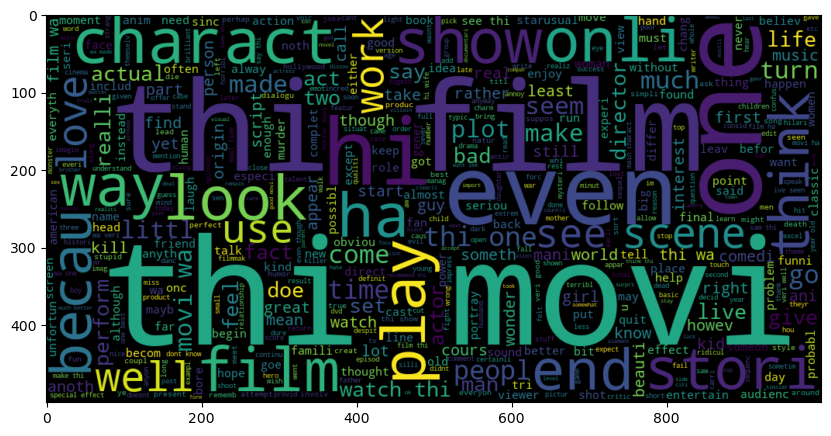

In [21]:
# # For all reivews 
# plt.figure(figsize=(10,10))
# WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
# all_words =WC.generate(string_texts)
# plt.imshow(all_words,interpolation='bilinear')
# plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

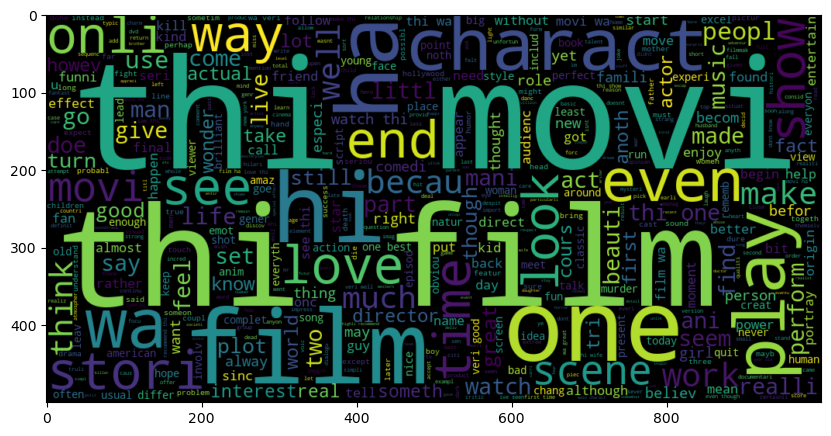

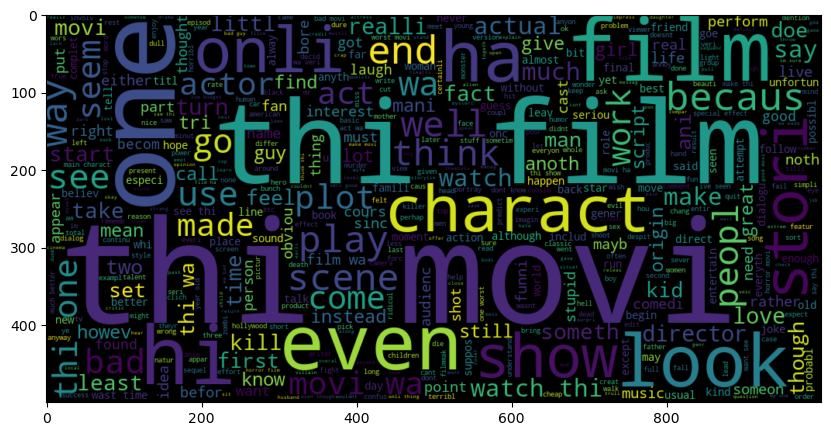

In [22]:
# # For positive reviews
# plt.figure(figsize=(10,10))
# WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
# all_words =WC.generate(pos_string_texts)
# plt.imshow(all_words,interpolation='bilinear')
# plt.show

# # For negative reviews
# plt.figure(figsize=(10,10))
# WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
# all_words =WC.generate(neg_string_texts)
# plt.imshow(all_words,interpolation='bilinear')
# plt.show


Word clouds show nothing informative when plotting bags of words. We believe plotting tf-idf will be more informative if we have enough computational power.

In [23]:
# #Attempt to convert Tf-idf vector back to word for wordcloud, but it exceeds its computational capacity

# # Get the feature names from the TfidfVectorizer
# feature_names = tv.get_feature_names_out()

# # Create a dictionary mapping feature indices to feature names
# feature_dict = dict(zip(range(len(feature_names)), feature_names))

# # Create a dense matrix of the tf-idf values
# dense_matrix = tv_train_reviews.todense()

# # Get the tf-idf scores for each feature
# tfidf_scores = dense_matrix.mean(axis=0).tolist()[0]

# # Create a dictionary mapping feature names to tf-idf scores
# tfidf_dict = dict(zip(feature_names, tfidf_scores))

# # Create a WordCloud object with the desired parameters
# wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='inferno', stopwords=None, min_font_size=10)

# # Generate the word cloud from the tf-idf dictionary
# wordcloud.generate_from_frequencies(tfidf_dict)

# # Display the word cloud
# plt.figure(figsize=(8,8), facecolor=None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

## Unigram, Bigram, Trigram analysis 

In [98]:
# count_bad = count_bad.replace('br','', regex=True)
# count_bad = count_bad.replace('</br>','', regex=True)
# count_good = count_good.replace('\n','', regex=True)


def get_corpus(text):
    words = []
    tags_to_remove = ['<br>', '</br>', '/><br', 'br', 'br>']

    # deleted = ['<br>', '</br>', '/><br', 'br', 'br>']
    for i in text:
        for j in i.split():
            words.append(j.strip())
            words = [word for word in words if not any(tag in word for tag in tags_to_remove)]
            # words = [word.replace('<br>', '') if '<br>' in word else word for word in my_list]

    return words
corpus = get_corpus(imdb_data.review)
pos_corpus = get_corpus(count_good.review)
neg_corpus = get_corpus(count_bad.review)


def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

KeyboardInterrupt: 

In [96]:
most_common_uni = get_top_text_ngrams(corpus[:100],20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

Text(0.5, 1.0, 'Top 20 Commmon Words Unigram')

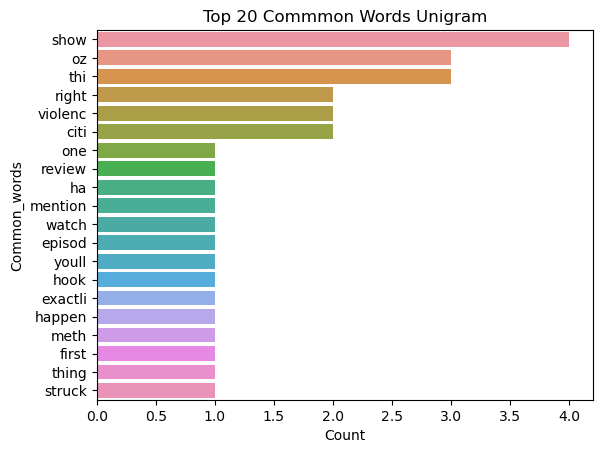

In [85]:
fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Unigram")

In [97]:
pos_corpus

['One',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'Oz',
 'episode',
 "you'll",
 'be',
 'hooked.',
 'They',
 'are',
 'right,',
 'as',
 'this',
 'is',
 'exactly',
 'what',
 'happened',
 'with',
 'me.<br',
 '/><br',
 '/>The',
 'first',
 'thing',
 'that',
 'struck',
 'me',
 'about',
 'Oz',
 'was',
 'its',
 'brutality',
 'and',
 'unflinching',
 'scenes',
 'of',
 'violence,',
 'which',
 'set',
 'in',
 'right',
 'from',
 'the',
 'word',
 'GO.',
 'Trust',
 'me,',
 'this',
 'is',
 'not',
 'a',
 'show',
 'for',
 'the',
 'faint',
 'hearted',
 'or',
 'timid.',
 'This',
 'show',
 'pulls',
 'no',
 'punches',
 'with',
 'regards',
 'to',
 'drugs,',
 'sex',
 'or',
 'violence.',
 'Its',
 'is',
 'hardcore,',
 'in',
 'the',
 'classic',
 'use',
 'of',
 'the',
 'word.<br',
 '/><br',
 '/>It',
 'is',
 'called',
 'OZ',
 'as',
 'that',
 'is',
 'the',
 'nickname',
 'given',
 'to',
 'the',
 'Oswald',
 'Maximum',
 'Security',
 'State',
 'Penitentar

Text(0.5, 1.0, 'Top 20 Commmon Words Bigram for bad reviews')

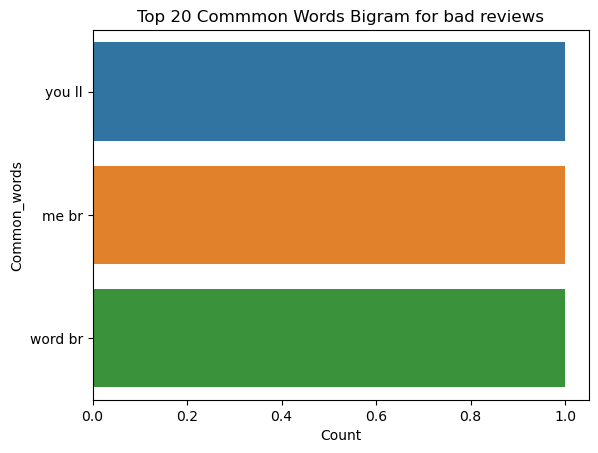

In [87]:
most_common_uni = get_top_text_ngrams(pos_corpus[:100],20,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

fig = sns.barplot(temp, x="Count", y="Common_words", orientation='horizontal')
plt.title("Top 20 Commmon Words Bigram for bad reviews")

Bi-gram analysis


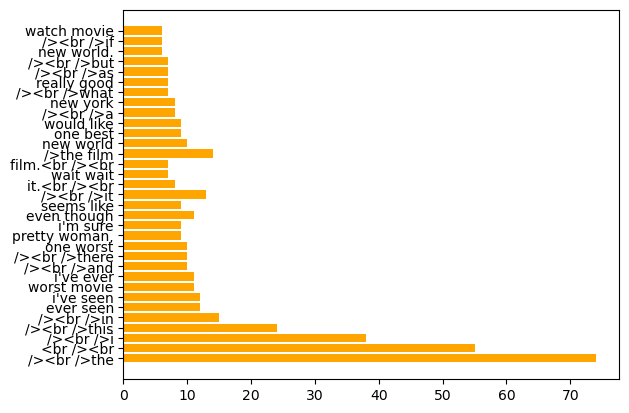

In [25]:
# def gram_analysis(data,gram):
#     tokens=[t for t in data.lower().split(" ") if t!="" if t not in stopword_list]
#     ngrams=zip(*[tokens[i:] for i in range(gram)])
#     final_tokens=[" ".join(z) for z in ngrams]
#     return final_tokens


# #Create frequency grams for analysis
    
# def create_dict(data,grams):
#     freq_dict=defaultdict(int)
#     for sentence in data:
#         for tokens in gram_analysis(sentence,grams):
#             freq_dict[tokens]+=1
#     return freq_dict

# def horizontal_bar_chart(df, color):
#     trace = plt.barh(
#     y=df["n_gram_words"],
#     width=df["n_gram_frequency"],
#     color=color,
# )
#     return trace



# def create_new_df(freq_dict,):
#     freq_df=pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
#     freq_df.columns=['n_gram_words','n_gram_frequency']
#     #print(freq_df.head())
#     #plt.barh(freq_df['n_gram_words'][:20],freq_df['n_gram_frequency'][:20],linewidth=0.3)
#     #plt.show()
#     trace=horizontal_bar_chart(freq_df[:20],'orange')
#     return trace
    
# # def plot_grams(trace_zero,trace_one):
# #     fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
# #                           subplot_titles=["Frequent words of positive reviews", 
# #                                           "Frequent words of negative reviews"])
# #     fig.append_trace(trace_zero, 1, 1)
# #     fig.append_trace(trace_ones, 1, 2)
# #     fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
# #     py.iplot(fig, filename='word-plots')
    
    
# # train_df_zero=count_bad['review']
# # train_df_ones=count_good['review']

# print("Bi-gram analysis")
# freq_train_df_zero=create_dict(neg_reviews[:200],2)
# #print(freq_train_df_zero)
# trace_zero=create_new_df(freq_train_df_zero)
# freq_train_df_ones=create_dict(pos_reviews[:200],2)
# #print(freq_train_df_zero)
# trace_ones=create_new_df(freq_train_df_ones)
# # plot_grams(trace_zero,trace_ones)
# # print("Tri-gram analysis")
# # freq_train_df_zero=create_dict(train_df_zero[:200],3)
# # #print(freq_train_df_zero)
# # trace_zero=create_new_df(freq_train_df_zero)
# # freq_train_df_ones=create_dict(train_df_ones[:200],3)
# # #print(freq_train_df_zero)
# # trace_ones=create_new_df(freq_train_df_ones)
# # plot_grams(trace_zero,trace_ones)


## BERT model

### What's special about BERT? 
- Context-free models:generate a single word embedding representation for each word in the vocabulary,  such as word2vec or GloVe. For example, the word “bank” would have the same representation in “bank deposit” and in “riverbank”
- Contextual models instead generate a representation of each word that is based on the other words in the sentence, such as BERT.

### Understand how BERT works
1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. **This allows the encoder to distinguish between sentences.**
3. Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

![BERT model structure](https://towardsml.files.wordpress.com/2019/09/input.png)


1. Masked LM (MLM)
The idea here is “simple”: Randomly mask out 15% of the words in the input — replacing them with a [MASK] token.  Loss function considers only the prediction of the masked tokens and ignores the prediction of the non-masked ones.

2. Next Sentence Prediction (NSP)
In order to understand relationship between two sentences, BERT training process also uses next sentence prediction, BERT separates sentences with a special [SEP] token. During training the model is fed with two input sentences at a time such that:
- 50% of the time the second sentence comes after the first one.
- 50% of the time it is a a random sentence from the full corpus.

Example: predict if the next sentence is random or not 

![BERTseq](https://towardsml.files.wordpress.com/2019/09/nsp-1.png)


Important note: BERT does not try to predict the next word in the sentence!!

### Tokenizer for BERT

BERT uses what is called a WordPiece tokenizer. It works by splitting words either into the full forms (e.g., one word becomes one token) or into word pieces — where one word can be broken into multiple tokens.

| Word          | Token(s)                           |
| ------------- | ---------------------------------- |
| surf          | \['surf'\]                         |
| surfing       | \['surf', '##ing'\]                 |
| surfboarding  | \['surf', '##board', '##ing'\]       |
| surfboard     | \['surf', '##board'\]               |
| snowboard     | \['snow', '##board'\]               |
| snowboarding  | \['snow', '##board', '##ing'\]       |
| snow          | \['snow'\]                         |
| snowing       | \['snow', '##ing'\]                 |

By splitting words into word pieces, we have already identified that the words "surfboard" and "snowboard" share meaning through the wordpiece "##board" We have done this without even encoding our tokens or processing them in any way through BERT.

### BERT model choice
BERT model we choose 
**DistilBERT** vs BERT
- DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark.

**BERT-base** vs BERT-large: BERT-based
- BERT-Base: 12-layer, 768-hidden-nodes, 12-attention-heads, 110M parameters
- BERT-Large: 24-layer, 1024-hidden-nodes, 16-attention-heads, 340M parameters

BERT-based-case vs **BERT-base-uncased**:
- We don't differentiate between cased and uncased data (english vs English)

### BERT input 

Input IDs – The input ids are often the only required parameters to be passed to the model as input. Token indices, numerical representations of tokens building the sequences that will be used as input by the model.

Attention mask – Attention Mask is used to avoid performing attention on padding token indices. Mask value can be either 0 or 1, 1 for tokens that are NOT MASKED, 0 for MASKED tokens.

Token type ids – It is used in use cases like sequence classification or question answering. As these require two different sequences to be encoded in the same input IDs. Special tokens, such as the classifier[CLS] and separator[SEP] tokens are used to separate the sequences.


Note: Padding is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences

### BERT tokens

`CLS`: The [CLS] token, short for "classification," is a special token used in BERT to represent the entire input sequence for classification tasks. 

When training a classification model using BERT, the [CLS] token is added to the beginning of the input sequence, and the final hidden state corresponding to this token is used as the input to a classifier. This allows the model to make a prediction for the entire input sequence.

`SEP`: The [SEP] token, short for "separator," is used to separate two different segments of a sentence or document. 

In BERT, the [SEP] token is used to separate the two segments when performing tasks like question answering or natural language inference, where the model needs to understand the relationship between two different segments of text.

`MASK`: [MASK] is used during pre-training to randomly mask some of the input tokens, forcing the model to learn to predict the masked tokens based on the surrounding context.

![image](https://editor.analyticsvidhya.com/uploads/79452bert-text-classification-input.width-1280.png)


### Understanding the parameters 
`max_length` is a parameter used to define the maximum length of an input sequence. 

`pad_to_max_length` is a Boolean parameter used to indicate whether sequences shorter than the max_length should be padded with a special token, usually [PAD], to make them the same length as the longest sequence in the batch. 

`return_tensors` parameter specifies that we want the encoded data to be returned as TensorFlow tensor

`attention_mask`: 1 indicates a value that should be attended to, while 0 indicates a padded value. 

Example: 

`sequence_a = "This is a short sequence."`
`sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."`
`len(encoded_sequence_a), len(encoded_sequence_b)`

(8, 19)

`padded_sequences = tokenizer([sequence_a, sequence_b], padding=True)`
`padded_sequences["input_ids"]`

[[101, 1188, 1110, 170, 1603, 4954, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1188, 1110, 170, 1897, 1263, 4954, 119, 1135, 1110, 1120, 1655, 2039, 1190, 1103, 4954, 138, 119, 102]]

`padded_sequences["attention_mask"]`

[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [25]:
import transformers
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

Resources
- [BERT Explained: A Complete Guide with Theory and Tutorial](https://towardsml.wordpress.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/)

In [27]:
# Encode the training data
encoded_train_data = tokenizer(train_reviews.values.tolist(), padding=True, truncation=True, return_tensors='pt')

# Print the encoded data
print(encoded_train_data)

{'input_ids': tensor([[ 101, 2028, 1997,  ...,    0,    0,    0],
        [ 101, 1037, 6919,  ...,    0,    0,    0],
        [ 101, 1045, 2245,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 2265,  ...,    0,    0,    0],
        [ 101, 1996, 2755,  ...,    0,    0,    0],
        [ 101, 1045, 2031,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [29]:
from transformers import BertModel

# Load the pre-trained BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Get the embeddings for the encoded data
outputs = bert_model(encoded_train_data['input_ids'], attention_mask=encoded_train_data['attention_mask'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

: 

In [3]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
True


In [4]:
dtype = torch.float
device = torch.device("mps")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

RuntimeError: The MPS backend is supported on MacOS 12.3+.Current OS version can be queried using `sw_vers`

In [ ]:
bert_model.summary()

### BERT vs RoBERTa

RoBERTa model shares the same architecture as the BERT model. It is a reimplementation of BERT with some modifications to the key hyperparameters and minor embedding tweaks.


The key differences between RoBERTa and BERT can be summarized as follows:

- RoBERTa is a reimplementation of BERT with some modifications to the key hyperparameters and minor embedding tweaks. It uses a byte-level BPE as a tokenizer (similar to GPT-2) and a different pretraining scheme.
- RoBERTa is trained for longer sequences, too, i.e. the number of iterations is increased from 100K to 300K and then further to 500K.
- RoBERTa uses larger byte-level BPE vocabulary with 50K subword units instead of character-level BPE vocabulary of size 30K used in BERT.
- In the Masked Language Model (MLM) training objective, RoBERTa employs dynamic masking to generate the masking pattern every time a sequence is fed to the model.
- RoBERTa doesn’t use token_type_ids, and we don’t need to define which token belongs to which segment. Just separate segments with the separation token tokenizer.sep_token (or ).
- The next sentence prediction (NSP) objective is removed from the training procedure.
- Larger mini-batches and learning rates are used in RoBERTa’s training.
